## Figure 2: Single-cell RNA (scRNA) validation

- Author: Mai T.N. Nguyen
- Email: mai.tn.nguyen@helsinki.fi/ ntnmai303@gmail.com
- Git: https://github.com/maitnnguyen

In [90]:
# setup
suppressMessages({
    library(dplyr)
    library(ggplot2)
    library(ggpubr)
})

genome_size = 2900.078 # in Mb
# set colors
list_color <- c('#cc3333', '#339933', "#003399")
project_dir <- '/mnt/storageBig8/work/nguyenma/projects/ctDNA/ctDNA_release/ctDNArelease_Omics_Integration'

In [82]:
## load data
# ctdna cohort
project_dir <- '/mnt/storageBig8/work/nguyenma/projects/ctDNA/ctDNA_release/ctDNArelease_Omics_Integration/'
cfdna_df <- read.delim(paste0(project_dir, "data/ctdna_at_diagnosis.tsv"))
clinical_df <- read.delim(paste0(project_dir, "data/ctdna_clinical_data.tsv"))

# integrate genomic data
dna_data <- read.delim(paste0(project_dir, "data/dna_cohort.tsv"))
highest_purity_dna <- dna_data |>
    #filter(sample %in% mut_sbs_sample_count$sample) |>
    dplyr::slice_max(purity, by = c(patientID)) |>
    # priority samples for patients that have more than 1 highest purity samples
    # H091 & H116: prioritize Ome, H245: same tissue, exclude novaseq
    filter(!(sample %in% c('H245_pOme1_DNA1_novaseq','H116_pPer2_DNA1','H091_pOvaL1_DNA1')))

mutation_burden <- read.delim(paste0(project_dir, "data/dna_burden.tsv"))

### Figure 2a & 2b: variant burgen between ctDNA groups 

In [ ]:
genome_size = 2900.078 # in Mb
fig3a <- mutation_burden |> 
    as.data.frame() |> 
    ggplot(aes(x=factor(ctdna_lev, 
                        levels = c('low', 'med', 'high')), 
               y = breaks/genome_size)) +
    geom_boxplot(aes(color=factor(ctdna_lev, 
                                  levels = c('low', 'med', 'high'))),
                 outlier.shape = NA,
                 show.legend = F, width=.5) +
    geom_dotplot(aes(fill=factor(ctdna_lev, 
                                 levels = c('low', 'med', 'high'))),
                 show.legend = F,
                 binaxis='y', stackdir='center', dotsize=.7) +
    scale_color_manual(values = list_color) +
    scale_fill_manual(values = list_color) +
    #stat_compare_means(size=5, label.y.npc = .85) +
    stat_compare_means(comparisons = list(c('low', 'med'),
                                          c('high', 'med'),
                                          c('high', 'low')),
                       label = '.p.', size=5,
                       label.y = c(.75,.85,.95), 
                       tip.length = .01) +
    labs(fill='ctDNA level', x='', y = 'Avg N Breakpoints per Megabase') +
    theme_pubr() +
    theme(axis.title = element_text(size=15), 
          axis.text.y = element_text(size=13),
          axis.text.x = element_blank(),
          legend.position = 'none',
          legend.text = element_text(size=10),
          legend.title = element_text(size=12),
          strip.text.x = element_text(size = 15))

fig3b <- mutation_burden |>
    ggplot(aes(x = factor(ctdna_lev, 
                          levels = c('low', 'med', 'high')), 
               y = mutation)) +
    geom_boxplot(aes(color=factor(ctdna_lev, 
                                  levels = c('low', 'med', 'high'))),
                 outlier.shape = NA, width=.5) +
    geom_dotplot(aes(fill=factor(ctdna_lev, 
                                 levels = c('low', 'med', 'high'))),
                 show.legend = F,
                 binaxis='y', stackdir='center', dotsize=.7) +
    scale_color_manual(values = list_color) +
    scale_fill_manual(values = list_color) +
    stat_compare_means(comparisons = list(c('high', 'med'),
                                          c('low', 'med'),
                                          c('high', 'low')),
                       label = '..p..', size=5,
                       label.y = c(13,11,15), 
                       tip.length = .01) +
    labs(x = '', y='Mutation Count per Megabase', fill='ctDNA Level') +
    #ylim(c(0,.4)) +
    theme_pubr() +
    theme(axis.title = element_text(size=15), 
          axis.text.y = element_text(size=13),
          axis.text.x = element_blank(),
          legend.position = 'none',
          legend.text = element_text(size=10),
          legend.title = element_text(size=12),
          strip.text.x = element_text(size = 15))


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


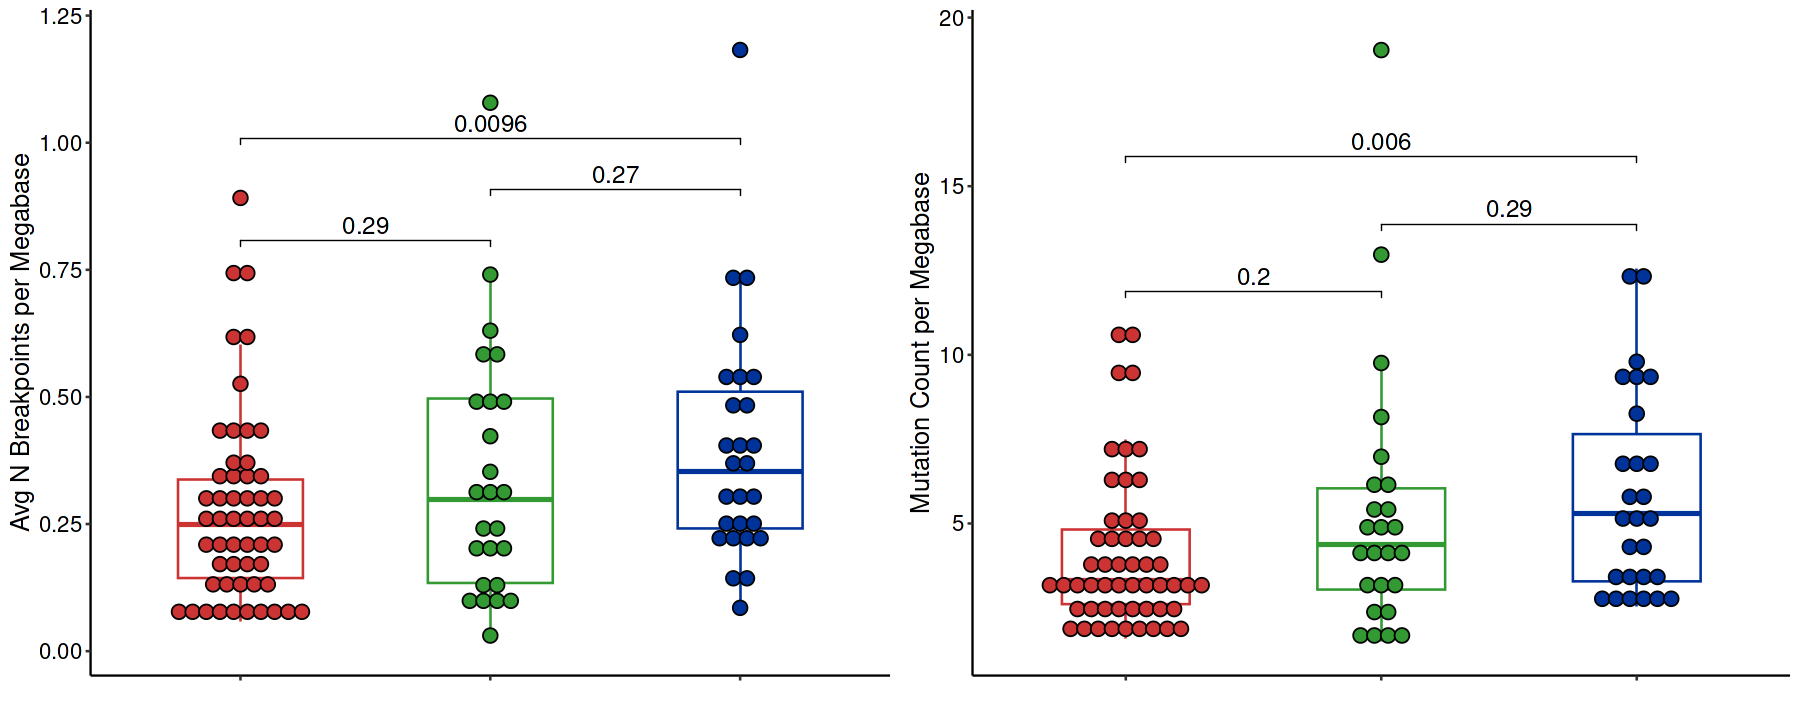

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 6)

#svg('/mnt/storageBig8/work/nguyenma/projects/ctDNA/ctDNA_release/ctDNArelease_Omics_Integration/figures/main/2ab_variant_burden.svg',
#    width = 6.5, height = 4)
ggarrange(fig3a, fig3b, ncol=2)
#dev.off()

### Figure 2c: burden by mutational signatures between ctDNA groups

Comparing mutation count by mutational signature type: SBS, DBS, ID

In [95]:
signature_burden_count <- read.delim(paste0(project_dir, "/data/dna_signature_burden_count.tsv"))
signature_burden_prop <- read.delim(paste0(project_dir, "/data/dna_signature_burden_prop.tsv"))

In [ ]:
mut_sigs <- signature_burden_count |>
    dplyr::select(patientID:id_count) |>
    tidyr::gather(key = 'type', value = 'mut_count', 
                         sbs_count:id_count) 

fig3c <- mut_sigs |>
    ggplot(aes(x = factor(ctdna_lev, levels = c('low', 'med', 'high')),
               y = mut_count/genome_size)) + #geom_boxplot()
    geom_jitter(
      aes(color = factor(ctdna_lev, 
                         levels = c('low', 'med', 'high'))), 
      position = position_jitterdodge(jitter.width = 1, dodge.width = .4),
      size = 2, show.legend = F
    ) +
    stat_summary(color = 'black', fun.data="mean_sdl",  
                 fun.args = list(mult=1), 
                 geom = "pointrange",  size = 1,
                 position = position_dodge(1))+
    scale_color_manual(values = list_color) +
    facet_wrap(~factor(type, levels=c('sbs_count', 'dbs_count', 'id_count'),
                      labels=c('SBS', 'DBS', 'ID')), 
               scales = 'free_y') +
    stat_compare_means(comparisons = list(c('low', 'med'),
                                          c('high', 'med'),
                                          c('high', 'low')),
                       label = 'p.format', size=5,
                       method = "wilcox.test",
                       p.adjust.method = "BH",
                       label.y.npc = c(.5,.5,.5), 
                       tip.length = .0) +
    scale_color_manual(values = list_color) +
    labs(y='Mutation Count per Megabase', x ='') +
    theme_pubr() +
    theme(panel.grid.major.y = element_blank(),
          panel.grid.minor = element_blank(),
          axis.title = element_text(size=15), 
          axis.text.x = element_blank(),
          axis.text.y = element_text(size=13),
          legend.position = c(.85,.75),
          legend.text = element_text(size=10),
          legend.title = element_text(size=12),
          strip.text.x = element_text(size = 15))


Warning message in wilcox.test.default(c(0.0237924635130503, 0.0220683719541336, :
“cannot compute exact p-value with ties”


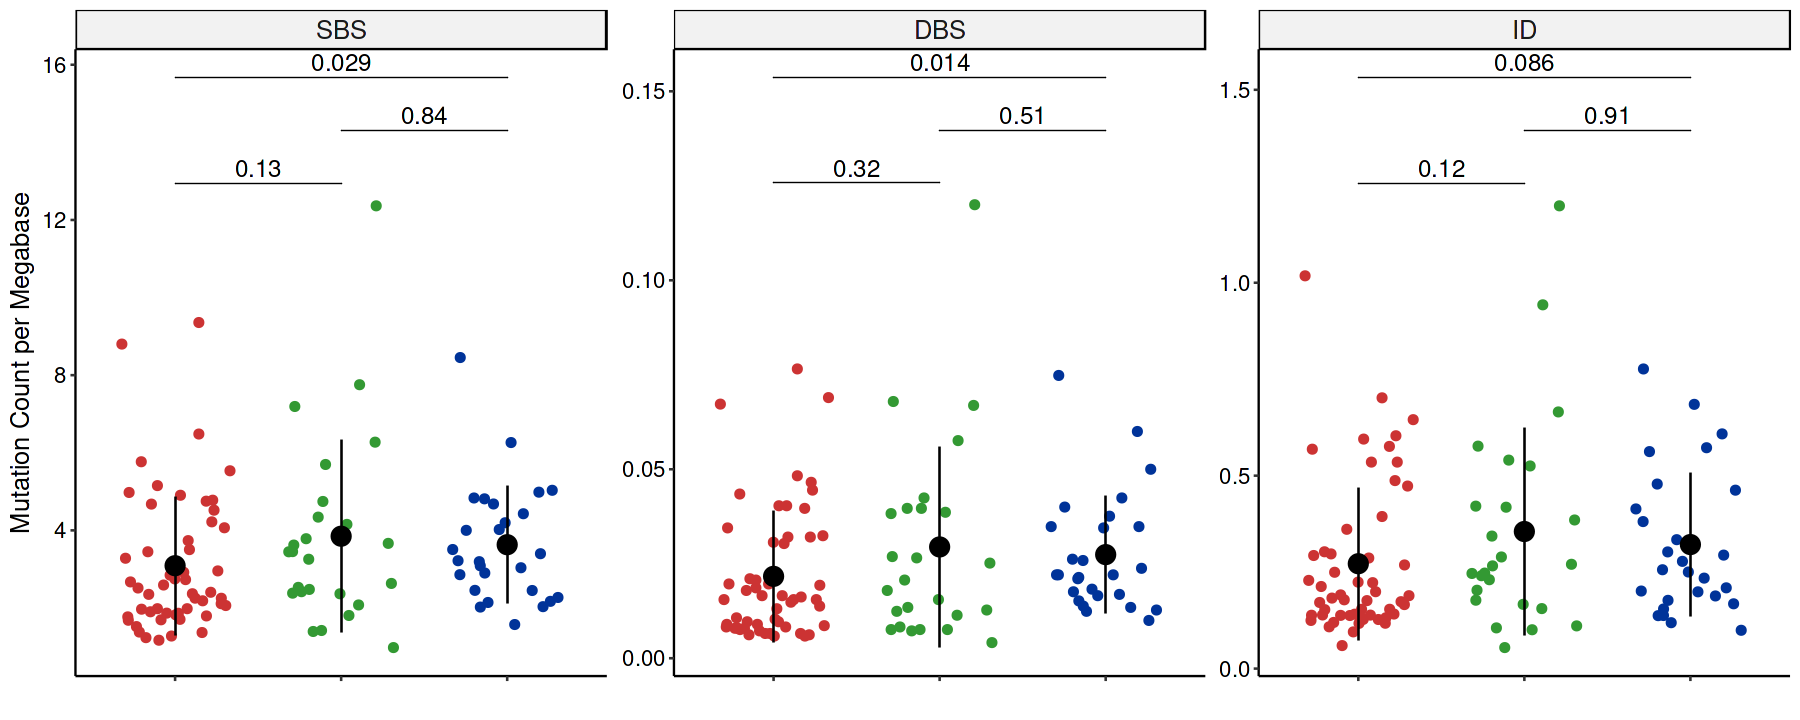

In [110]:
options(repr.plot.width = 15, repr.plot.height = 6)
#svg('/mnt/storageBig8/work/nguyenma/projects/ctDNA/ctDNA_release/ctDNArelease_Omics_Integration/figures/main/2c_burden_by_sig_type.svg', width = 6, height = 4)
fig3c
#dev.off()

### Figure 2d: PCA to evaluate driving factors of ctDNA TF based on burden by signature types and copy-number break points

### Figure 2e: Proportion of MAGEB copy-number status between ctDNA groups

In [124]:
cna_df = read.delim(paste0(project_dir, "/data/dna_CNA_hotspots.tsv"))
  
fig3f <- cna_df |> 
ggplot(aes(x = factor(ctdna_lev, levels=c('low','med','high')))) + #geom_bar()
geom_bar(aes(fill = factor(MAGEB10.status, levels=c('gain/normal','loss/deletion'))),
        position = 'fill', color='black', show.legend = T) +
#scale_color_manual(name="ctdna_lev", values = list_color) +
scale_fill_manual(name="MAGEB10 status",
                values = c("#e0eeee","#00008b")) +
theme_classic() +
labs(y = 'Proportion', x = "ctDNA level group") +
annotate("text", x=2, y =1.1, size = 5, family='Arial',
        label = paste0('X-squared: ',
                    round((chisq.test(cna_df$ctdna_lev, cna_df$MAGEB10.status))$stat,4), 
                    ',\np-value: ', 
                    round((chisq.test(cna_df$ctdna_lev, 
                                        cna_df$MAGEB10.status))$p.value,4))) +
theme(panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title = element_text(size=15), 
    axis.text = element_text(size=12),
    legend.position = c(.8,.95),
    legend.text = element_text(size=10),
    legend.title = element_text(size=15),
    strip.text.x = element_text(size = 13))


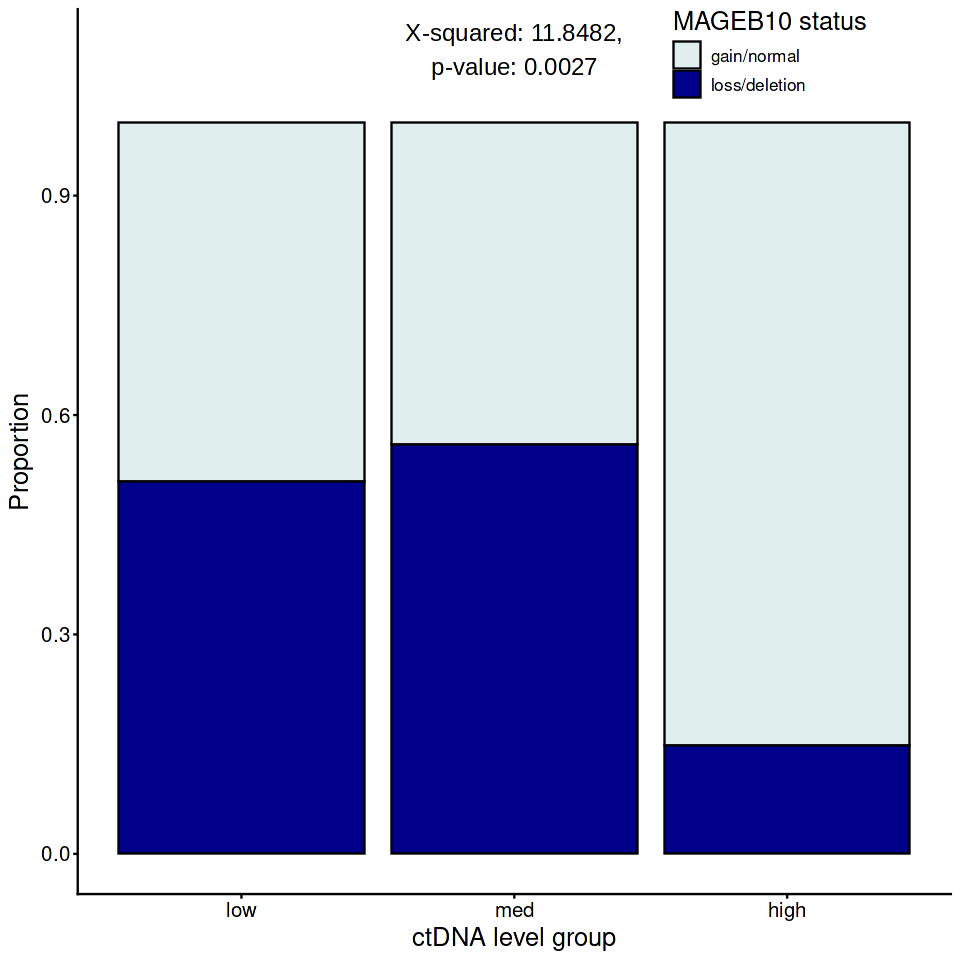

In [129]:
options(repr.plot.width = 8, repr.plot.height = 8)
#svg('results/figures_Dec25/mage.svg', width = 4, height = 5.5)
fig3f
#dev.off()


### Figure 3f & 3g: burden of mutational signatures SBS40 and ID5

In [ ]:
# SBS40
{
  fig3d <- mut_sbs_sample_count |>
    filter(sample %in% highest_purity_dna$sample) |>
    tidyr::gather(key = 'signature', value = 'count', SBS1:SBS85) |>
    as.data.frame() |>
    filter(signature %in% c('SBS40')) |>
    ggplot(aes(x = factor(ctdna_lev, 
                          levels = c('low', 'med', 'high')),
               y = count/genome_size)) +
    geom_jitter(
      aes(color = factor(ctdna_lev, 
                         levels = c('low', 'med', 'high'))), 
      position = position_jitterdodge(jitter.width = 1, dodge.width = .4),
      size = 2, show.legend = F
    ) +
    stat_summary(color = 'black', fun.data="mean_sdl",  
                 fun.args = list(mult=1), 
                 geom = "pointrange",  size = 1,
                 position = position_dodge(1))+
    scale_color_manual(values = list_color) +
    #stat_compare_means(size = 4, 
    #                     label.sep = '\n',
    #                     label.y.npc = .9) +
    stat_compare_means(comparisons = list(c('low', 'med'),
                                          c('high', 'med'),
                                          c('high', 'low')),
                       label = '..p..', size=5,
                       label.y = c(3,3.3,3.6), 
                       tip.length = .01) +
    labs(x='', y ='SBS40 count per Megabase') +
    theme_pubr() +
    theme(panel.grid.major.y = element_blank(),
          panel.grid.minor = element_blank(),
          axis.title = element_text(size=15), 
          axis.text.x = element_blank(),
          axis.text.y = element_text(size=13),
          legend.position = c(.85,.75),
          legend.text = element_text(size=10),
          legend.title = element_text(size=12),
          strip.text.x = element_text(size = 15)) 
  fig3d
  svg('results/figures_Dec25/sbs40.svg', width = 4, height = 3.5)
  fig3d
  dev.off()
}
# ID5 prop
sig_df4 <- mut_id_sample_prop |>
  filter(sample %in% highest_purity_dna$sample) |>
  mutate(id5 = ifelse(ID5>0, 'non-zero', 'zero'))
